# Selección del modelo

**Test 2 Prueba Data Science Capgemini**

**Javier Crespo Guerrero** (javicrespi2000@gmail.com)

En este notebook desarrollaremos la metodología de selección y evaluación del modelo de regresión.

## Metodología de selección del modelo
Partiremos de una serie de modelos a considerar en los que tendremos que realizar dos evaluaciones:
1. El tuning de hiperparámetros, lo cual haremos mediante el método de backtesting. En este método, utilizaremos los n primeros datos para entrenar un modelo con unos parámetros dados y lo utilizaremos para predecir los n + 100 periodos siguientes. Esto lo realizaremos 5 veces, cada una utilizando los n, n+100, n+200, n+300, n+400 primeros datos para entrenar el modelo y predeciremos los 100 posteriores. La media de estos 5 ensayos nos dará la métrica de rendimiento con la que evaluaremos cada configuración de parámetros para un modelo dado.
2. La evaluación del rendimiento del modelo con los parámetros tuneados, la cual realizaremos habiendo reservado una muestra de test.

Para ello, en primer lugar tendremos que dividir el dataset en dos: train y test; utilizaremos las 100 últimas observaciones para conjunto de test (puesto que el objetivo del ejercicio es predecir 100 periodos en adelante).
Utilizaremos la muestra train para el backtesting para el tuning de hiperparámetros y la muestra test para la comparación entre modelos ya tuneados. Con todo ello, nos quedaremos con el modelo que mejores resultados arroje.

## Métricas de evaluación

Vamos a utilizar el **Root Mean Squared Error (RMSE)** como métrica de evaluación, ya que considero que es la métrica más adecuada al enfatizar dar más peso a desviaciones más grandes.

En este caso estamos midiendo la temperatura del aceite dentro de un transfromador, por lo que una predicción muy desviada de la realidad parece bastante perjudicial. Además, como ya vimos, no parece haber outliers en los datos por lo que a priori esta métrica parece la más adecuada.

### Sobre los Modelos a considerar

Como una de las limitaciones es predecir 100 periodos asumiendo que no se conocen los datos de las variables regresoras tenemos que ajustarnos a modelos que permitan este tipo de configuraciones o *past covariates* a la hora de entrenar un modelo y hacer predicciones.

In [ ]:
# Tratamiento y modelado de Series Temporales
from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler
import pandas as pd
import numpy as np

# Visualizacion
import matplotlib.pyplot as plt
from darts.utils.statistics import plot_residuals_analysis

# Modelos
from darts.models import BlockRNNModel, NBEATSModel, RandomForest

# Metrica
from darts.metrics.metrics import rmse

# Parametros necesarios
RANDOM_SEED = 2024

TARGET = "OT"
DATE = "date"

PAST_COVARIATES = ["HUFL", "HULL", "MUFL", "MULL", "LUFL", "LULL"]

In [ ]:
# Lectura de los datos
# df = pd.read_csv('/home/javier/capgemini-prueba-tecnica/jcg-testdatascience-2/data/electricity_transformer.csv')
series = TimeSeries.from_csv(
    "/home/javier/capgemini-prueba-tecnica/jcg-testdatascience-2/data/electricity_transformer.csv",
    DATE,
    [TARGET] + PAST_COVARIATES,
)

In [3]:
series.columns, len(series)

(Index(['OT', 'HUFL', 'HULL', 'MUFL', 'MULL', 'LUFL', 'LULL'], dtype='object', name='component'),
 2083)

## Partición de los datos

A continuación mostraremos cómo se descomponen los datos en train y test y como se dividirá el conjunto de train para el backtesting.

1983
100


<Axes: xlabel='date'>

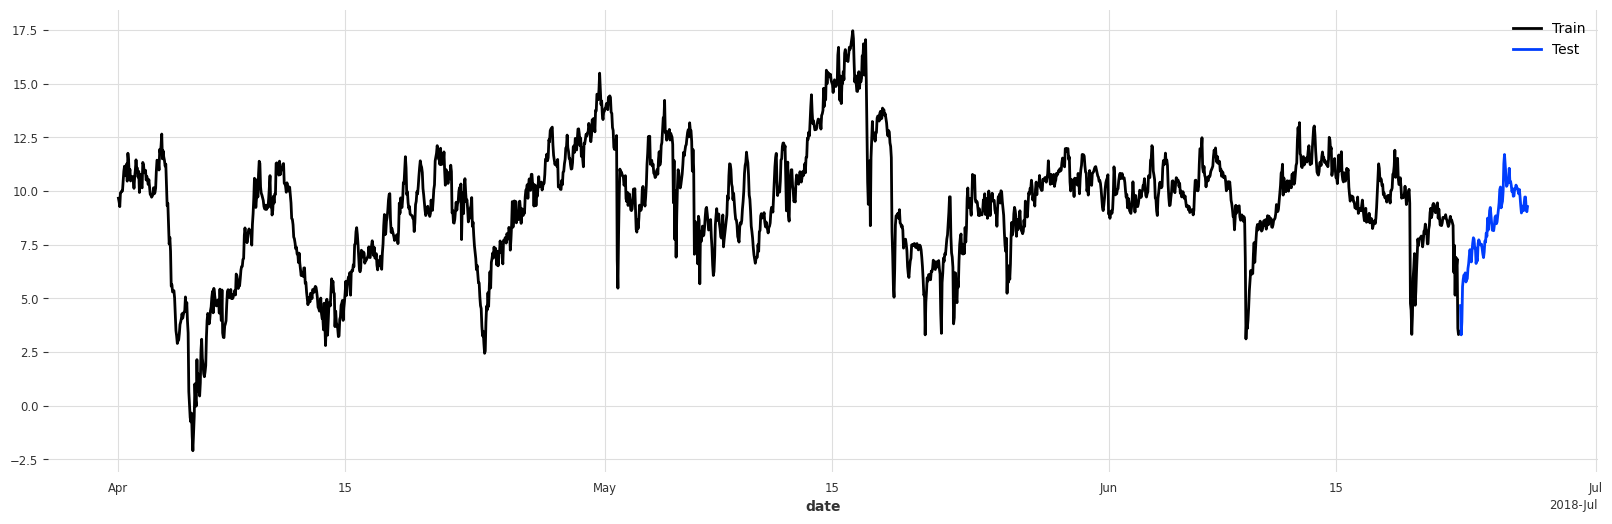

In [ ]:
# Division en train y test
train, test = series[:-100], series[-100:]
print(len(train))
print(len(test))

plt.figure(figsize=(20, 6))
train[TARGET].plot(label="Train")
test[TARGET].plot(label="Test")

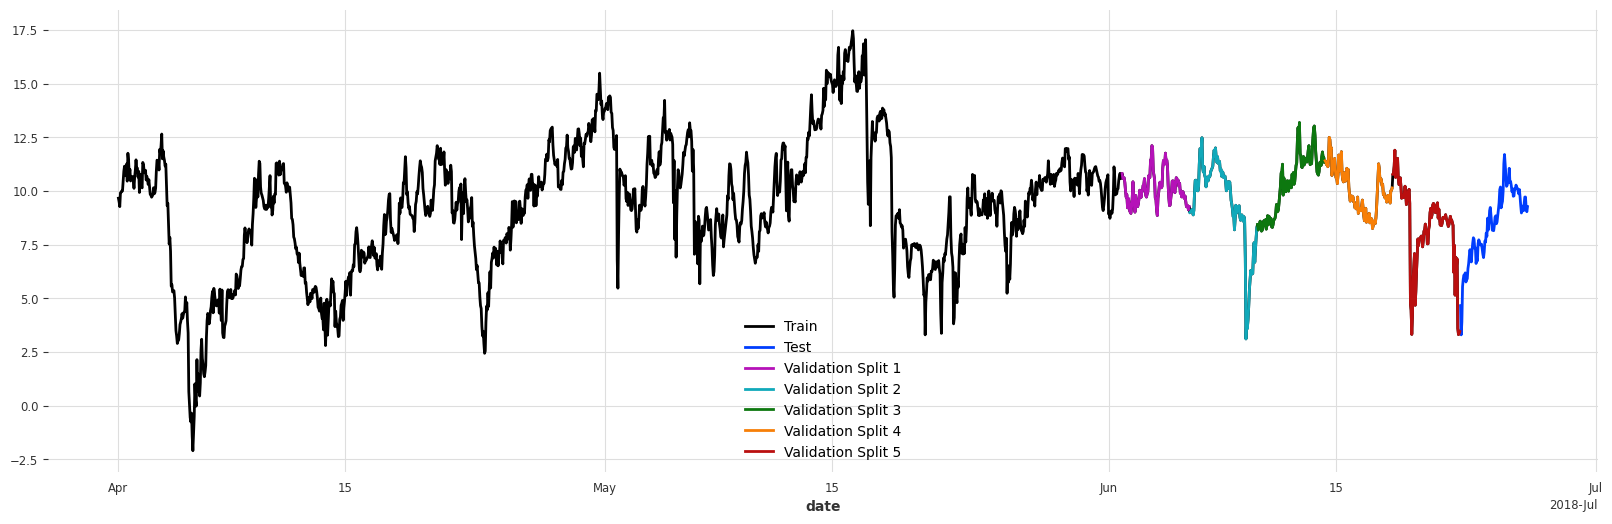

In [ ]:
plt.figure(figsize=(20, 6))
train[TARGET].plot(label="Train")
test[TARGET].plot(label="Test")
for k in range(5):
    split = train[(-100 * (5 - k)) : ((-100 * (4 - k)) if k != 4 else None)]
    split[TARGET].plot(label=f"Validation Split {k+1}")

## Estandarizado

Antes de entrenar un modelo, necesitamos estandarizar los datos. En este caso utilizaremos MixMaxScaler, adecuado para trabajar con Redes Neuronales. Notese que no podemos utilizar el conjunto de train completo para el escalado, pues estaríamos introduciendo datos para la evaluación de los splits de validación en el estandarizado, por lo que usamos el conjunto de train sin los splits de validación para entrenar el scaler que utilizaremos para escalar el conjunto de datos. Esto también podríamos hacerlo dentro de cada split de validación, pero por simplicidad lo vamos a hacer con los splits de validación agrupados.

In [ ]:
scaler = Scaler()  # Darts utiliza MinMaxScaler por defecto
train_wo_val, val = train[:-500], train[-500:]
scaler.fit(train_wo_val)
train = scaler.transform(train)
test = scaler.transform(test)

## Backtesting para tuning de hiperparámetros

Vamos a utilizar Grid Search como método para tunear los hiperparámetros del modelo, donde comprobaremos cada una de las combinaciones de parámetros y asignaremos una puntuación a cada mediante el backtesting que definimos anteriormente. La combinación de parámetros que arroje menor RMSE medio en los 5 splits será la escogida para cada modelo. 

*NOTA: Este método sólo se utiliza en casos muy sencillos y con pocos hiperparámetros, por lo que en un caso más realista habría que utilizar otras opciones (darts, por ejemplo, recomienda las librerías Optuna y Ray Tune). Sin embargo, para este ejercicio de prueba como este utilizaremos el método básico. Por limitaciones de tiempo y recursos, nos ceñiremos al método básico en este ejercicio.*

### Los modelos considerados

Como no tenemos ningún requisito sobre el modelo a escoger, vamos a escoger modelos que permitan utilizar covariables pasadas (cuyo valor desconozcamos a la hora de hacer predicciones futuras). En este caso, por simplicidad y limitación de tiempo, hemos escogido 3 modelos: BlockRNN, N-BEATS y Random Forest.

In [ ]:
considered_models = [
    (
        "Block-Recurrent Neural Network",
        BlockRNNModel(input_chunk_length=50, output_chunk_length=100),
        {
            # Version mas realista de los parámetros
            # 'input_chunk_length': [200],
            # 'output_chunk_length': [100],
            # 'model': ['RNN', 'LSTM', 'GRU'],
            # 'hidden_dim': [25, 32, 64, 128],
            # 'n_rnn_layers': [1, 2, 3],
            # 'dropout': [0.0, 0.2, 0.4, 0.5],
            # Version que utilizaremos por limitaciones de tiempo
            "input_chunk_length": [50],
            "output_chunk_length": [100],
            "model": ["RNN"],
            "hidden_dim": [32, 64],
            "n_rnn_layers": [1, 2],
            "dropout": [0.0, 0.2],
            "random_state": [RANDOM_SEED],
        },
    ),
    (
        "N-BEATS",
        NBEATSModel(input_chunk_length=50, output_chunk_length=100),
        {
            # Version mas realista de los parámetros
            # 'input_chunk_length': [5],
            # 'output_chunk_length': [5],
            # 'num_stacks': [10, 20, 30],
            # 'num_blocks': [1, 2, 3],
            # 'num_layers': [4, 8],
            # 'layer_widths': [64, 128, 256, 512],
            # 'expansion_coefficient_dim': [3, 5, 10],
            # 'dropout': [0.0, 0.1, 0.2, 0.5],
            # Version que utilizaremos por limitaciones de tiempo
            "input_chunk_length": [50],
            "output_chunk_length": [100],
            "num_layers": [4, 8],
            "dropout": [0.0, 0.2],
            "random_state": [RANDOM_SEED],
        },
    ),
    (
        "Random Forest",
        RandomForest(lags=100, lags_past_covariates=100, output_chunk_length=100),
        {
            # Version mas realista de los parámetros
            # 'n_estimators': [50, 100, 200],
            # 'max_depth': [None, 10, 20, 30],
            # 'multi_models': [True, False],
            # Version que utilizaremos por limitaciones de tiempo
            "lags": [100],
            "lags_past_covariates": [100],
            "output_chunk_length": [100],
            "max_depth": [None, 20],
            "multi_models": [True, False],
            "random_state": [RANDOM_SEED],
        },
    ),
]

In [ ]:
tuning_results = []
for name, base_model, params in considered_models:
    # Realizamos el gridsearch
    best_model_, best_params_, score_ = base_model.gridsearch(
        parameters=params,
        series=train[TARGET],
        past_covariates=train[PAST_COVARIATES],
        start=1483,
        forecast_horizon=100,
        stride=100,
        verbose=True,
        metric=rmse,
        last_points_only=False,
        n_jobs=-1,
    )

    # Entrenamos el mejor modelo con el dataset completo
    best_model_.fit(series=train[TARGET], past_covariates=train[PAST_COVARIATES])
    predictions_ = best_model_.predict(100, past_covariates=train[PAST_COVARIATES])
    #
    final_score_ = rmse(test[TARGET], predictions_)

    # Predecimos el conjunto de test
    tuning_results += [[name, best_model_, best_params_, score_, final_score_]]

In [ ]:
tuning_results_df = pd.DataFrame(
    [
        [name, best_params_, score_, final_score_]
        for name, _, best_params_, score_, final_score_ in tuning_results
    ],
    columns=["Model", "Best Parameters", "Backtesting RMSE", "Test RMSE"],
)
tuning_results_df

,Model,Best Parameters,Backtesting RMSE,Test RMSE
0,Block-Recurrent Neural Network,"{'input_chunk_length': 50, 'output_chunk_lengt...",0.084051,0.037654
1,N-BEATS,"{'input_chunk_length': 50, 'output_chunk_lengt...",0.103135,0.078973
2,Random Forest,"{'lags': 100, 'lags_past_covariates': 100, 'ou...",0.077147,0.037400


A pesar de contar con datos muy reducidos, vemos que hemos podido sacar un buen RMSE contra la muestra de test. Los modelos de Block-RNN y Random Forest parecen bastante parecidos, pero vamos a utilizar Random Forest por haber obtenido algo menos de error tanto en el backtesting como en el RMSE.

De todas formas, vamos a comparar las predicciones que hacen los tres modelos finales contra el conjunto de test de manera visual.

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

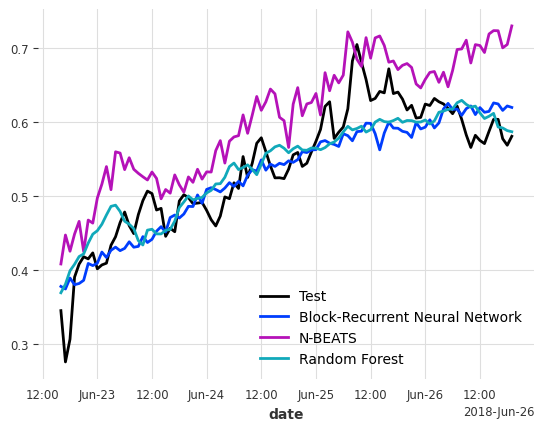

In [ ]:
test[TARGET].plot(label="Test")
for name_, model_, _, _, _ in tuning_results:
    model_.predict(100, past_covariates=series[PAST_COVARIATES]).plot(label=name_)

El modelo de N-BEATS sí que parece tener sesgos al predecir siempre por encima de los datos reales. De nuevo, las predicciones de Block-RNN y Random Forest son bastante parecidas. A simple vista el rendimiento parece bueno; hay que tener en cuenta que hemos eliminado la estacionalidad de la serie, que suele ser una parte fundamentar de las predicciones.

Vamos a estudiar los residuos de este último modelo, que es el que utilizaremos para las predicciones finales.

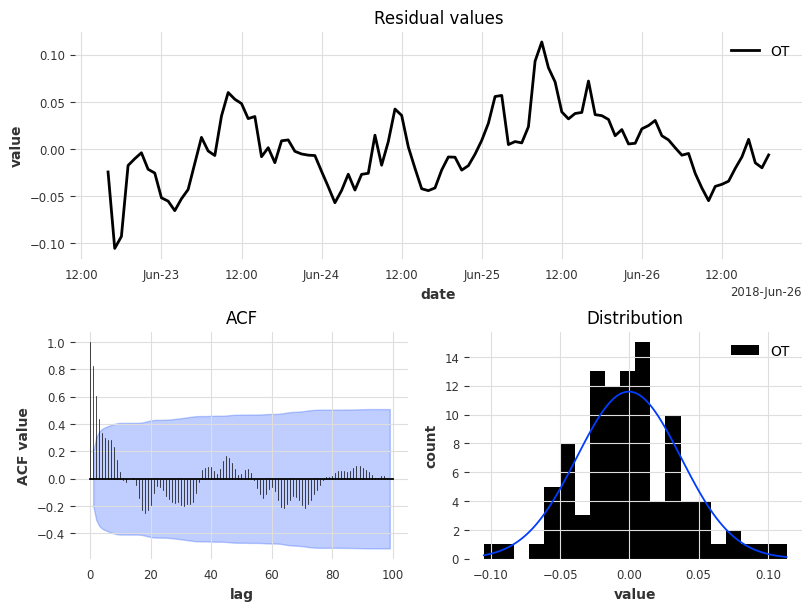

In [22]:
rf_model = tuning_results[2][1]
rf_preds = rf_model.predict(100, past_covariates=series[PAST_COVARIATES])
rf_residuals = test[TARGET] - rf_preds
plot_residuals_analysis(rf_residuals, acf_max_lag=100)

En el gráfico de tiempo no parece haber tendencias claras o ciclos que sean indicativos de un mal ajuste del modelo, la varianza también parece permanecer constante con el tiempo. El histograma de los residuos está agrupado en torno al 0 y no parece haber sesgos importantes en las predicciones. En cuanto al correlograma quizás parezca haber algo de estacionalidadd latente en el retardo 7 pero, teniendo en cuenta las limitaciones de tiempo y recursos, podemos decir que el modelo no tiene fallos importantes.

## Predicciones finales

Una vez hemos seleccionado el modelo podemos entrenarlo con el conjunto completo de datos y predecir 100 periodos en adelante. Ahora ya podemos usar el conjunto completo de datos para estandarizar y realizar las predicciones.

In [ ]:
final_model = RandomForest(
    **{
        "lags": 100,
        "lags_past_covariates": 100,
        "output_chunk_length": 100,
        "max_depth": None,
        "multi_models": True,
        "random_state": RANDOM_SEED,
    }
)

scaled_series = scaler.fit_transform(series)
final_model.fit(
    series=scaled_series[TARGET], past_covariates=scaled_series[PAST_COVARIATES]
)

RandomForest(lags=100, lags_past_covariates=100, lags_future_covariates=None, output_chunk_length=100, output_chunk_shift=0, add_encoders=None, n_estimators=100, max_depth=None, multi_models=True, use_static_covariates=True, random_state=2024)

<Axes: xlabel='date'>

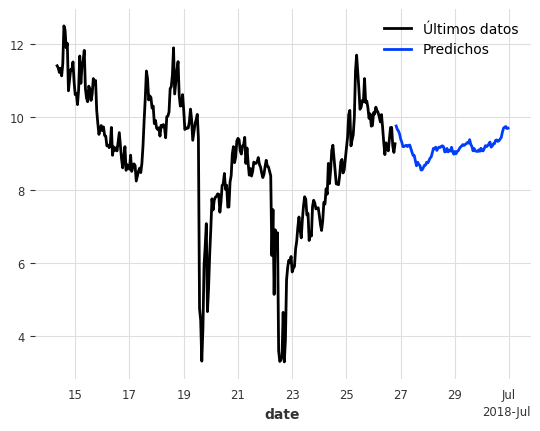

In [ ]:
final_predictions = final_model.predict(100)
# Tenemos que revertir el escalado para expresar las predicciones finales en las unidades correctas
# Añadimos series dummy para obtener 7 series con las que poder ejecutar la funcion inverse_transform
dates = pd.date_range(start="2018-06-26 20:00:00", periods=100, freq="h")
dummy_data = np.random.rand(100)
dummy_series = TimeSeries.from_times_and_values(
    dates, dummy_data, columns=["Initial Series"]
)

for i in range(6):
    final_predictions = final_predictions.stack(dummy_series)

final_predictions = scaler.inverse_transform(final_predictions)
series[TARGET][-300:].plot(label="Últimos datos")
final_predictions["OT"].plot(label="Predichos")

Con todo esto ya estaríamos listos para pasar el modelo a producción.